# Problem Definition
Recurrent Neural Networks (RNNs)  have shown a lot of potential in many natural language processing (NLP) and sequence learning tasks. The main idea behind sequential learning is that they make use of sequential information. In traditional feed-forward neural networks such as Convolutional Neural Networks (CNNs), it is assumed that all inputs are independent of each other, e.g., in an image classification task, the pixels of an image are independent of each other. However, this approach is not valid for sequence learning tasks. For instance, if you want to predict the next word in a sequence (sentence), you need the prior information (i.e., previous words in the sentence) to do so. RNNs can remember previous states (information), i.e., RNNs have a “memory” in the form of hidden states which store information about what has been processed so far. At each input of the sequence, the model not only takes the current input but also remembers the preceding information. Like the human way of processing sequential information, this allows the model to learn long-term dependencies in the sequence, i.e., it considers the entire context when making a prediction. 

Prediction of the next alarm can also be modelled as a sequence learning task: given a sorted sequence of alarms based on their start time, predict the upcoming alarm. In this report, we compared a RNN architecture and a Transfomrer architecture in terms of accuracy of predicitng next alarm. 

By predicting future alarms in real-time with the help of the AI module, the operator may avert abnormal situations by taking corrective actions or prepare for such situations in advance.






In [13]:
# # for logging 

from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.loggers import TestTubeLogger
from pytorch_lightning.loggers import WandbLogger
import wandb

# For metrics
from pytorch_lightning import metrics

import math
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import io
import torchtext
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import pytorch_lightning as pl
from pytorch_lightning.trainer.trainer import Trainer





from pytorch_lightning.callbacks.early_stopping import EarlyStopping # The EarlyStopping callback can be used to monitor a validation metric and stop the training when no improvement is observed.
"""
    To enable it:

    Import EarlyStopping callback.

    Log the metric you want to monitor using log() method.

    Init the callback, and set monitor to the logged metric of your choice.

    Pass the EarlyStopping callback to the Trainer callbacks flag.
"""

from pytorch_lightning import seed_everything
seed_everything(42)

42

### Performance Metrics

In [14]:
from pytorch_lightning.metrics import Metric
from pytorch_lightning.metrics.utils import _input_format_classification
from sklearn.metrics import classification_report
class MyClassificationReport(Metric):
    def __init__(self,threshold: float = 0.5,compute_on_step: bool = True,dist_sync_on_step: bool = False):
        super().__init__(
            compute_on_step=compute_on_step,
            dist_sync_on_step=dist_sync_on_step,
        )

        self.threshold = threshold
        self.add_state("preds", default=[], dist_reduce_fx=None)
        self.add_state("target", default=[], dist_reduce_fx=None)

        # rank_zero_warn(
        #     'Metric `MyClassificationReport` will save all targets and predictions in buffer.'
        #     ' For large datasets this may lead to large memory footprint.'
        # )

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        preds = preds.cpu()
        target = target.cpu()
        y_hat, y = preds.max(1).indices, target
        assert y_hat.shape == y.shape
        self.preds.append(y_hat)
        self.target.append(y)

    def compute(self):
        preds = torch.cat(self.preds, dim=0)
        target = torch.cat(self.target, dim=0)

### Dataset Prepartion

In [15]:
from sklearn.model_selection import train_test_split

class AlarmDataset(Dataset):
    def __init__(self,data,seq_len,batch_size):
        self.length = len(data)//seq_len # how much data i have         
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
       
    def __getitem__(self, index: int):
        x = self.data[index*self.seq_len:(index*self.seq_len)+self.seq_len]
        y = self.data[1+index*self.seq_len:1+(index*self.seq_len)+self.seq_len]
        return x,y
    
    def __len__(self) -> int:
        return self.length

class MyDataModule(pl.LightningDataModule):
    
    def __init__(self,config):
        super().__init__()
        self.config = config
        dir_path = self.config['dir-path']
        file_name = 'train.tokens'

        self.tokenizer = get_tokenizer('basic_english')
        self.vocab = build_vocab_from_iterator(map(self.tokenizer,iter(io.open(dir_path+file_name,encoding="utf8"))))
    

        train_data = self.data_process(iter(io.open(dir_path +"train.tokens", encoding="utf8")))
        val_data = self.data_process(iter(io.open(dir_path +"val.tokens", encoding="utf8")))
        test_data = self.data_process(iter(io.open(dir_path +"test.tokens", encoding="utf8")))

    
        self.train_dataset = AlarmDataset(train_data, self.config['seq-len'], self.config['batch-size'])
        self.valid_dataset = AlarmDataset(val_data,self.config['seq-len'], self.config['batch-size'])
        self.test_dataset = AlarmDataset(test_data, self.config['seq-len'], self.config['batch-size'])

    
    def data_process(self, raw_text_iter):
        data = [torch.tensor([self.vocab[token] for token in self.tokenizer(item)],dtype=torch.long) for item in raw_text_iter]
        return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))
    
    def get_weight_per_class(self):
        def lambdaFun(total,v,num_classes):
            if v>0:
                return total/(v*num_classes) 
            return 0
        
        index_2_count = {self.vocab.stoi[k]:self.vocab.freqs[k]  for k in list(self.vocab.stoi)}
        total = sum(index_2_count.values())
        index_2_ws = {k:lambdaFun(total,v,len(index_2_count)) for k,v in index_2_count.items()}
        index_2_ws[1] = 0.0 # MANUALLY Setting the weights to zero for the padding
        # index_2_ws[0] = 0.0 # MANUALLY Setting the weights to zero for the padding
        ws = torch.tensor([index_2_ws[i] for i in range(len(index_2_ws))])

        return ws

    def prepare_data(self):
        """
            Use this method to do things that might write to disk or that need to be done only from a single GPU in distributed settings.
            e.g., download,tokenize,etc…
        """ 
        return None


    def setup(self, stage: None):
        """
            There are also data operations you might want to perform on every GPU. Use setup to do things like:
            count number of classes,build vocabulary,perform train/val/test splits,apply transforms (defined explicitly in your datamodule or assigned in init),etc…
        """
        return None

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=8,drop_last=True, pin_memory=True)
    
    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.valid_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=8,drop_last=True, pin_memory=True)
    
    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=8,drop_last=True, pin_memory=True)



# Transformer Model

The alarm modeling task is to assign a
probability for the likelihood of a given sequence of words
to follow a next alarm. A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word. The
``nn.TransformerEncoder`` consists of multiple layers of
`nn.TransformerEncoderLayer <https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLayer>`__. Along with the input sequence, a square
attention mask is required because the self-attention layers in
``nn.TransformerEncoder`` are only allowed to attend the earlier positions in
the sequence. For the language modeling task, any tokens on the future
positions should be masked. To have the actual alarms, the output
of ``nn.TransformerEncoder`` model is sent to the final Linear
layer, which is followed by a log-Softmax function.


# Positional Encoding

``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens (i.e.,) in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.

# Loss Function

`CrossEntropyLoss` is applied to track the loss and `AdamW`implements stochastic gradient descent method as the optimizer.






In [16]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Transformer Architecture

In [17]:
class TransformerModel(pl.LightningModule):

    def __init__(self, config):
        super(TransformerModel, self).__init__()
        self.accuraccy_50_count = 0
        self.config = config        
        self.lr = self.config["lr"]
        self.weight_decay = self.config["weight-decay"]
    
        self.pos_encoder = PositionalEncoding(self.config['em-size'], self.config['dropout'])
        encoder_layers = torch.nn.TransformerEncoderLayer(self.config['em-size'], self.config['nhead'], self.config['nhid'], self.config["dropout"])
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, self.config['nlayers'])
        self.encoder = torch.nn.Embedding(self.config["vocab-size"], self.config['em-size'])
        self.decoder = torch.nn.Linear(self.config['em-size'], self.config["vocab-size"])
        self.src_mask = self.generate_square_subsequent_mask(self.config['seq-len'])
        self.init_weights()

        self.class_weight = self.config['weight_per_class']

        # self.train_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        # self.val_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        # self.test_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        
        self.val_CM_normalized = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')
        self.val_CM_raw = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"])

        self.train_CM_normalized = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')
        self.train_CM_raw = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"])

        self.test_CM = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')

        self.val_MCR = MyClassificationReport()
        self.test_MCR = MyClassificationReport()

        self.log("Sequence length",self.config['seq-len'])
        self.log("lr",self.lr)
        self.log("# of tokens/vocab_size (unique alarms)",self.config['vocab-size'])
        self.log("weight_decay",self.weight_decay)
        self.save_hyperparameters()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src_mask = src_mask.to(self.device)
        src = self.encoder(src) * math.sqrt(self.config['em-size'])
        src = self.pos_encoder(src)
        src_mask = src_mask.to(self.device)
      
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        
        return output

   # The ReduceLROnPlateau scheduler requires a monitor
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        d = {
       'optimizer': optimizer,
       'lr_scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", factor = 0.5, patience=10, verbose=True),
       'monitor': 'val_epoch_loss',
        'interval': 'epoch'
        }
        return d 

    def loss_function(self,logits,y):
        return F.cross_entropy(logits,y,weight= self.class_weight,ignore_index=1) 

    def myPrintToFile(self,cm_normal,cm_raw,f):
        cm_normal = cm_normal.cpu()
        cm_raw = cm_raw.cpu()
        

        sum_of_each_class = cm_raw.sum(axis=1) # sum along the columns
        print(f"        ------ Epoch {self.current_epoch} ---------",file=f)
        print(f"Total={[v.item() for v in sum_of_each_class]}",file=f)
        print(f"Corret={[v.item() for v in torch.diagonal(cm_raw,0)]}",file=f)
        print(f"Accuracy={[round(v.item(),3) for v in (torch.diagonal(cm_raw,0)/sum_of_each_class)]}",file=f)

        accs = [round(v.item(),3)  for v in torch.diagonal(cm_normal,0)]

        source2acc = {self.config['vocab'].itos[i]:accs[i] for i in range(len(accs))}

        source2_acc50 = {self.config['vocab'].itos[i]:accs[i] for i in range(len(accs)) if accs[i]>=0.5}

        print(f"Acc2={accs}",file=f)
        print(f"source2_acc= {source2acc}",file=f)
        print(f"source2_acc50= {source2_acc50}",file=f)

        a_50 = len([a for a in accs if a>=0.5])
        a_30 = len([a for a in accs if a>=0.3])
        out_str = f"acc>0.5= {a_50}, acc>=0.3= {a_30}, Total={len(accs)}"
        print(out_str,file=f)

        


        # if temp> self.accuraccy_50_count and train=:
        #     self.accuraccy_50_count = temp
        print(out_str,end=" ") 

      

    def training_step(self,batch,batch_idx):
        x,y = batch
        x = x.T
        y = y.T.reshape(-1)

        if x.size(0) != self.config['seq-len']:
           self.src_mask =  self.generate_square_subsequent_mask(x.size(0))
        
        y_hat = self(x,self.src_mask)
        y_hat =  y_hat.view(-1, self.config['vocab-size'])
        loss = self.loss_function(y_hat,y) # cross entropy itself compute softmax 

        self.train_CM_normalized(F.softmax(y_hat),y)
        self.train_CM_raw(F.softmax(y_hat),y)
        
        self.log('train_loss',loss,logger=True)
        # self.log('train_F1',self.train_F1(F.softmax(y_hat),y),logger=True)
        return loss

    def validation_step(self,batch, batch_idx):
        x,y = batch
        x = x.T
        y = y.T.reshape(-1)
        
        if x.size(0) != self.config['seq-len']:
            # print(f">> passed {x.size()}")
            self.src_mask =  self.generate_square_subsequent_mask(x.size(0))
        
        y_hat = self(x,self.src_mask)
        y_hat =  y_hat.view(-1, self.config['vocab-size'])
        loss = self.loss_function(y_hat,y)

        self.val_MCR(F.softmax(y_hat),y)
        self.val_CM_normalized(F.softmax(y_hat),y)
        self.val_CM_raw(F.softmax(y_hat),y)

        self.log('val_loss',loss,logger=True)
        # self.log('val_F1',self.val_F1(F.softmax(y_hat) ,y),logger=True)
        return {'val_loss':loss}
    
    def test_step(self,batch, batch_idx):
        x,y = batch
        x = x.T
        y = y.T.reshape(-1)
        if x.size(0) != self.config['seq-len']:
           self.src_mask =  self.generate_square_subsequent_mask(x.size(0))

        y_hat = self(x,self.src_mask)
        y_hat =  y_hat.view(-1,  self.config['vocab-size'])
        loss = self.loss_function(y_hat,y)

        self.test_MCR(F.softmax(y_hat),y)
        self.log('test_loss',loss,logger=True)
        # self.log('test_F1', self.test_F1(F.softmax(y_hat) ,y),logger=True)
        return {'test_loss':loss}
    
    def training_epoch_end(self, outputs):

        avg_loss = torch.stack([d['loss']  for d in outputs]).mean()
        # f1 = self.train_F1.compute()
        print(f"[{self.current_epoch}]E, Avg Training loss = {round(avg_loss.item(),4)}",end=" ")
        
        with open(self.config["train-file"],'a') as f:
            self.myPrintToFile(self.train_CM_normalized.compute(),self.train_CM_raw.compute(),f)
        self.log("train_epoch_loss",avg_loss,logger=True,prog_bar=True)
        # self.log("train_epoch_F1", f1, logger=True,prog_bar=True)
  
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([d['val_loss'] for d in outputs]).mean()
        # f1 = self.val_F1.compute()
        # print(self.val_MCR.compute(),file=open("val-out.txt",'w'))
        # print(self.val_CM.compute(),file=open("val-cm-out.txt",'w'))

        # if self.current_epoch%4==0 and self.current_epoch>0:
        # self.myPrintToFile(self.val_CM_normalized.compute(),self.val_CM_raw.compute())


        print(f"::Val Loss = {round(avg_loss.item(),4) }",end=" ")

        with open(self.config["val-file"],'a') as f:
            self.myPrintToFile(self.val_CM_normalized.compute(),self.val_CM_raw.compute(),f)
        
        print("")


        self.log("val_epoch_loss",avg_loss,logger=True)
        # self.log("val_epoch_F1",f1,logger=True,prog_bar=True)
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([d['test_loss'] for d in outputs]).mean()
        # f1 = self.test_F1.compute()
        # print(self.test_MCR.compute(),file=open("test-out.txt",'w'))
        print(f">Average Test Loss = {avg_loss.item()}")
        self.log("test_epoch_loss",avg_loss, logger = True)
        # self.log("test_epoch_F1",f1, logger=True)
        
    

# RNN Architecture

In [18]:
class AlarmGRU(pl.LightningModule):
    
    def __init__(self,config):
        # super().__init__()
        super(AlarmGRU,self).__init__()
        self.config =config
        self.lr = self.config['lr']
        

        self.val_CM_normalized = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')
        self.val_CM_raw = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"])

        self.train_CM_normalized = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')
        self.train_CM_raw = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"])

        self.test_CM = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')

        self.val_MCR = MyClassificationReport()
        self.test_MCR = MyClassificationReport()




        ## TODO: define the layers of the model
        self.h = None
        self.embedding = torch.nn.Embedding(self.config['vocab-size'],self.config['em-size'])
        self.gru = torch.nn.GRU(input_size=self.config['em-size'], hidden_size=self.config['nhid'], num_layers=self.config['nlayers'],dropout=self.config['dropout'], batch_first=True)
        # self.droput = torch.nn.Dropout(p=self.drop_prob)
        self.fc3 = torch.nn.Linear(in_features=self.config['nhid'], out_features=self.config['vocab-size'])
        self.softmax = torch.nn.LogSoftmax(dim=1)  
    
    def __init_hidden(self):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of GRU
        device = None 
        if (torch.cuda.is_available()):
            device = torch.device("cuda")
        else:
            device = torch.device("cpu") 
        
        weight = next(self.parameters()).data
        hidden = weight.new(self.config['nlayers'], self.config['batch-size'], self.config['nhid']).zero_().to(device)
        return hidden

    def initialize_hidden(self):
        self.h = self.__init_hidden()
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        x = x.long()
        embeds = self.embedding(x)
        out, hidden = self.gru(embeds,hidden)
        # Contiguous variables: If you are stacking up multiple LSTM outputs, it may be necessary to use .contiguous() to reshape the output.
        out = out.contiguous().view(-1,self.config['nhid']) 
        out = self.fc3(out)
        out = self.softmax(out)
        # return the final output and the hidden state
        return out, hidden
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,weight_decay=self.config['weight-decay'])
        d = {
       'optimizer': optimizer,
       'lr_scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", factor = 0.5, patience=10, verbose=True),
       'monitor': 'val_epoch_loss',
        'interval': 'epoch'
        }
        return d

    # def loss_function(self,logits,y):
    #     return F.cross_entropy(logits,y,weight= self.class_weight,ignore_index=1) 

    def myPrintToFile(self,cm_normal,cm_raw,f):
        cm_normal = cm_normal.cpu()
        cm_raw = cm_raw.cpu()
        

        sum_of_each_class = cm_raw.sum(axis=1) # sum along the columns
        print(f"        ------ Epoch {self.current_epoch} ---------",file=f)
        print(f"Total={[v.item() for v in sum_of_each_class]}",file=f)
        print(f"Corret={[v.item() for v in torch.diagonal(cm_raw,0)]}",file=f)
        print(f"Accuracy={[round(v.item(),3) for v in (torch.diagonal(cm_raw,0)/sum_of_each_class)]}",file=f)

        accs = [round(v.item(),3)  for v in torch.diagonal(cm_normal,0)]

        source2acc = {self.config['vocab'].itos[i]:accs[i] for i in range(len(accs))}

        source2_acc50 = {self.config['vocab'].itos[i]:accs[i] for i in range(len(accs)) if accs[i]>=0.5}

        print(f"Acc2={accs}",file=f)
        print(f"source2_acc= {source2acc}",file=f)
        print(f"source2_acc50= {source2_acc50}",file=f)

        a_50 = len([a for a in accs if a>=0.5])
        a_30 = len([a for a in accs if a>=0.3])
        out_str = f"acc>0.5= {a_50}, acc>=0.3= {a_30}, Total={len(accs)}"
        print(out_str,file=f)

        


        # if temp> self.accuraccy_50_count and train=:
        #     self.accuraccy_50_count = temp
        print(out_str,end=" ")
    
    
    def training_step(self,batch,batch_idx):
        x,y = batch
        y =  y.view(self.config['batch-size']*self.config['seq-len']).long()

        self.h = self.h.data # for GRU
        y_hat, self.h = self(x,self.h)
        #  ignore_index=self.char2int["NoName"]
        loss = F.nll_loss(y_hat,y)
        
        self.train_CM_normalized(y_hat,y)
        self.train_CM_raw(y_hat,y)    
        # result = pl.TrainResult(loss) # logging
        self.log('train_loss',loss,logger=True)
        return loss
    
    def validation_step(self,batch, batch_idx):
        x,y = batch
        y =  y.view(self.config['batch-size']*self.config['seq-len']).long()

        self.h = self.h.data # for GRU
        y_hat, self.h = self(x,self.h)
        #  ignore_index=self.char2int["NoName"]
        loss = F.nll_loss(y_hat,y)
        
        self.val_CM_normalized(y_hat,y)
        self.val_CM_raw(y_hat,y)
        self.log('val_loss',loss,logger=True)
        return {'val_loss':loss}
    
    def test_step(self,batch, batch_idx):
        x,y = batch
        y =  y.view(self.config['batch-size']*self.config['seq-len']).long()

        self.h = self.h.data # for GRU
        y_hat, self.h = self(x,self.h)
        #  ignore_index=self.char2int["NoName"]
        loss = F.nll_loss(y_hat,y)
        
        self.val_CM_normalized(y_hat,y)
        self.val_CM_raw(y_hat,y)
        self.log('test_loss',loss,logger=True)
        return {'test_loss':loss}
    
    def training_epoch_end(self, outputs):

        avg_loss = torch.stack([d['loss']  for d in outputs]).mean()
        # f1 = self.train_F1.compute()
        print(f"[{self.current_epoch}]E, Avg Training loss = {round(avg_loss.item(),4)}",end=" ")
        
        with open(self.config["train-file"],'a') as f:
            self.myPrintToFile(self.train_CM_normalized.compute(),self.train_CM_raw.compute(),f)
        self.log("train_epoch_loss",avg_loss,logger=True,prog_bar=True)
        # self.log("train_epoch_F1", f1, logger=True,prog_bar=True)
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([d['val_loss'] for d in outputs]).mean()
        # f1 = self.val_F1.compute()
        # print(self.val_MCR.compute(),file=open("val-out.txt",'w'))
        # print(self.val_CM.compute(),file=open("val-cm-out.txt",'w'))

        # if self.current_epoch%4==0 and self.current_epoch>0:
        # self.myPrintToFile(self.val_CM_normalized.compute(),self.val_CM_raw.compute())


        print(f"::Val Loss = {round(avg_loss.item(),4) }",end=" ")

        with open(self.config["val-file"],'a') as f:
            self.myPrintToFile(self.val_CM_normalized.compute(),self.val_CM_raw.compute(),f)
        
        print("")


        self.log("val_epoch_loss",avg_loss,logger=True)
        # self.log("val_epoch_F1",f1,logger=True,prog_bar=True)

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([d['test_loss'] for d in outputs]).mean()
        # f1 = self.test_F1.compute()
        # print(self.test_MCR.compute(),file=open("test-out.txt",'w'))
        print(f">Average Test Loss = {avg_loss.item()}")
        self.log("test_epoch_loss",avg_loss, logger = True)
        # self.log("test_epoch_F1",f1, logger=True)
    


# Trainning Transformers

**Note: When monitoring any parameter after the validation epoch end then you should pass check_val_every_n_epoch=1  not to other. This is very important.**

### Finding the learning rate for the Transformer model.

48652lines [00:00, 81715.44lines/s]
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

   | Name                | Type                   | Params
----------------------------------------------------------------
0  | pos_encoder         | PositionalEncoding     | 0     
1  | transformer_encoder | TransformerEncoder     | 1.3 M 
2  | encoder             | Embedding              | 182 K 
3  | decoder             | Linear                 | 183 K 
4  | val_CM_normalized   | ConfusionMatrix        | 0     
5  | val_CM_raw          | ConfusionMatrix        | 0     
6  | train_CM_normalized | ConfusionMatrix        | 0     
7  | train_CM_raw        | ConfusionMatrix        | 0     
8  | test_CM             | ConfusionMatrix        | 0     
9  | val_MCR             | MyClassificationReport | 0     
10 | test_MCR            | MyClassificationReport | 0     
----------------------------------------------

Before [0.0, 0.0, 0.008, 0.009, 0.059, 0.061, 0.063, 0.075, 0.075, 0.075, 0.076, 0.078, 0.083, 0.098, 0.101, 0.11, 0.143, 0.157, 0.158, 0.172, 0.176, 0.18, 0.186, 0.187, 0.251, 0.269, 0.31, 0.327, 0.337, 0.344, 0.35, 0.363, 0.371, 0.377, 0.377, 0.389, 0.39, 0.404, 0.418, 0.419, 0.426, 0.428, 0.428, 0.467, 0.47, 0.476, 0.48, 0.48, 0.486, 0.492, 0.495, 0.495, 0.513, 0.531, 0.537, 0.539, 0.546, 0.576, 0.58, 0.601, 0.624, 0.629, 0.63, 0.644, 0.644, 0.654, 0.66, 0.662, 0.667, 0.673, 0.673, 0.687, 0.706, 0.707, 0.708, 0.735, 0.746, 0.749, 0.764, 0.785, 0.802, 0.803, 0.807, 0.827, 0.848, 0.904, 0.905, 0.905, 0.909, 0.911, 0.919, 0.935, 0.966, 0.976, 0.978, 0.982, 0.983, 1.004, 1.013, 1.03, 1.039, 1.05, 1.051, 1.054, 1.081, 1.082, 1.096, 1.109, 1.115, 1.124, 1.14, 1.141, 1.155, 1.16, 1.173, 1.177, 1.188, 1.198, 1.2, 1.201, 1.215, 1.235, 1.24, 1.25, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.264, 1.279, 1.283, 1.284, 1.303, 1.304, 1.316, 1.333, 1.338, 1.392, 1.398, 1.447, 

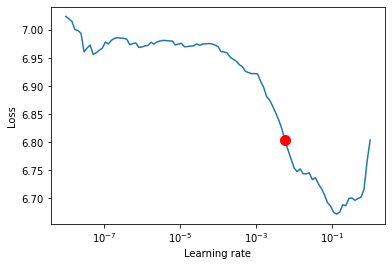

In [19]:
def weightCondition(w,avg_w):
    if w<avg_w:
        return w
    else:
        return avg_w

# setup data
config_data = {
'dir-path' : "../.data/",
'batch-size' :512, # Batch Size 
'seq-len' :128, # Sequence length
}

dm = MyDataModule(config=config_data)
ws = dm.get_weight_per_class().cuda()

print("Before",[round(w.item(),3) for w in ws])
# avg_w = sum(ws)/len(ws)
# ws = torch.tensor([weightCondition(w,avg_w) for w in ws]).cuda()
print("After",[round(w.item(),3) for w in ws])




config_model = {
    'lr' : 0.001,
    'dropout' : 0.2,
    'weight-decay': 3.1,
    'em-size' :256, # embedding dimension 
    'nhid' : 128, # the dimension of the feedforward network model in nn.TransformerEncoder
    'nlayers' :4, # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    'nhead' : 2, # the number of heads in the multiheadattention models
    'seq-len': config_data['seq-len'], # dont use wandb config 
    'vocab-size':len(dm.vocab.stoi), # the size of vocabulary /also called tokens
    'weight_per_class':ws,
    "val-file":"val-out.txt",
    "train-file":'train-out.txt',
    "vocab": dm.vocab
}

with open (config_model["val-file"],'w') as f:
    f.write(">> Starting")

with open (config_model["train-file"],'w') as f:
    f.write(">> Starting")

# setup model - note how we refer to sweep parameters with wandb.config
model = TransformerModel(config=config_model)

early_stop_callback = EarlyStopping(
        monitor='val_epoch_loss',
        min_delta=0,
        patience=600,
        verbose=True,
        mode='min'
)



trainer = Trainer(auto_lr_find=0.0001, precision=16,gpus=-1, num_nodes=1,  max_epochs=100, check_val_every_n_epoch=1,deterministic=True,gradient_clip_val=0.5,enable_pl_optimizer=True,callbacks=[early_stop_callback],progress_bar_refresh_rate=0)

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model,dm)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

print(f"Suggested lr = {new_lr}")

In [20]:
model.hparams.lr = new_lr/100 #7.5e-12 # can devide by 10

trainer.fit(model,dm) # Fit model




   | Name                | Type                   | Params
----------------------------------------------------------------
0  | pos_encoder         | PositionalEncoding     | 0     
1  | transformer_encoder | TransformerEncoder     | 1.3 M 
2  | encoder             | Embedding              | 182 K 
3  | decoder             | Linear                 | 183 K 
4  | val_CM_normalized   | ConfusionMatrix        | 0     
5  | val_CM_raw          | ConfusionMatrix        | 0     
6  | train_CM_normalized | ConfusionMatrix        | 0     
7  | train_CM_raw        | ConfusionMatrix        | 0     
8  | test_CM             | ConfusionMatrix        | 0     
9  | val_MCR             | MyClassificationReport | 0     
10 | test_MCR            | MyClassificationReport | 0     
----------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params


::Val Loss = 6.9607 acc>0.5= 1, acc>=0.3= 3, Total=714 
::Val Loss = 6.6953 acc>0.5= 2, acc>=0.3= 2, Total=714 
[1]E, Avg Training loss = 6.9605 acc>0.5= 0, acc>=0.3= 0, Total=714 ::Val Loss = 6.2927 acc>0.5= 4, acc>=0.3= 18, Total=714 
[2]E, Avg Training loss = 6.5591 acc>0.5= 1, acc>=0.3= 2, Total=714 ::Val Loss = 5.8698 acc>0.5= 26, acc>=0.3= 81, Total=714 
[3]E, Avg Training loss = 5.996 acc>0.5= 14, acc>=0.3= 37, Total=714 ::Val Loss = 5.503 acc>0.5= 59, acc>=0.3= 132, Total=714 
[4]E, Avg Training loss = 5.5356 acc>0.5= 46, acc>=0.3= 119, Total=714 ::Val Loss = 5.2612 acc>0.5= 78, acc>=0.3= 153, Total=714 
[5]E, Avg Training loss = 5.2409 acc>0.5= 80, acc>=0.3= 184, Total=714 ::Val Loss = 5.0282 acc>0.5= 89, acc>=0.3= 171, Total=714 
[6]E, Avg Training loss = 4.9778 acc>0.5= 105, acc>=0.3= 225, Total=714 ::Val Loss = 4.8711 acc>0.5= 104, acc>=0.3= 189, Total=714 
[7]E, Avg Training loss = 4.7696 acc>0.5= 127, acc>=0.3= 244, Total=714 ::Val Loss = 4.694 acc>0.5= 110, acc>=0.3= 198

1

In [21]:
# trainer.test(datamodule=dm) # testing

# Traninng RNNs
Finding the learning rate for the RNN model. 

48652lines [00:00, 86825.05lines/s]
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

   | Name                | Type                   | Params
----------------------------------------------------------------
0  | val_CM_normalized   | ConfusionMatrix        | 0     
1  | val_CM_raw          | ConfusionMatrix        | 0     
2  | train_CM_normalized | ConfusionMatrix        | 0     
3  | train_CM_raw        | ConfusionMatrix        | 0     
4  | test_CM             | ConfusionMatrix        | 0     
5  | val_MCR             | MyClassificationReport | 0     
6  | test_MCR            | MyClassificationReport | 0     
7  | embedding           | Embedding              | 182 K 
8  | gru                 | GRU                    | 4.3 M 
9  | fc3                 | Linear                 | 366 K 
10 | softmax             | LogSoftmax             | 0     
----------------------------------------------

Before [0.0, 0.0, 0.008, 0.009, 0.059, 0.061, 0.063, 0.075, 0.075, 0.075, 0.076, 0.078, 0.083, 0.098, 0.101, 0.11, 0.143, 0.157, 0.158, 0.172, 0.176, 0.18, 0.186, 0.187, 0.251, 0.269, 0.31, 0.327, 0.337, 0.344, 0.35, 0.363, 0.371, 0.377, 0.377, 0.389, 0.39, 0.404, 0.418, 0.419, 0.426, 0.428, 0.428, 0.467, 0.47, 0.476, 0.48, 0.48, 0.486, 0.492, 0.495, 0.495, 0.513, 0.531, 0.537, 0.539, 0.546, 0.576, 0.58, 0.601, 0.624, 0.629, 0.63, 0.644, 0.644, 0.654, 0.66, 0.662, 0.667, 0.673, 0.673, 0.687, 0.706, 0.707, 0.708, 0.735, 0.746, 0.749, 0.764, 0.785, 0.802, 0.803, 0.807, 0.827, 0.848, 0.904, 0.905, 0.905, 0.909, 0.911, 0.919, 0.935, 0.966, 0.976, 0.978, 0.982, 0.983, 1.004, 1.013, 1.03, 1.039, 1.05, 1.051, 1.054, 1.081, 1.082, 1.096, 1.109, 1.115, 1.124, 1.14, 1.141, 1.155, 1.16, 1.173, 1.177, 1.188, 1.198, 1.2, 1.201, 1.215, 1.235, 1.24, 1.25, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.264, 1.279, 1.283, 1.284, 1.303, 1.304, 1.316, 1.333, 1.338, 1.392, 1.398, 1.447, 

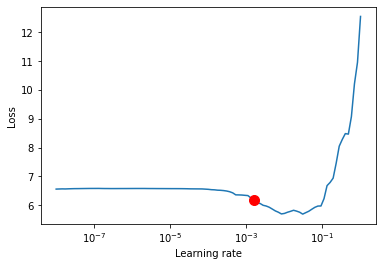

In [22]:
# setup data
config_data = {
'dir-path' : "../.data/",
'batch-size' :512, # Batch Size 
'seq-len' :128, # Sequence length
}

dm = MyDataModule(config=config_data)
ws = dm.get_weight_per_class().cuda()

print("Before",[round(w.item(),3) for w in ws])
# avg_w = sum(ws)/len(ws)
# ws = torch.tensor([weightCondition(w,avg_w) for w in ws]).cuda()
print("After",[round(w.item(),3) for w in ws])


config_model = {
    'lr' : 0.001,
    'dropout' : 0.05,
    'weight-decay': 3.1, #3.1,
    'em-size' :256, # embedding dimension 
    'nhid' : 512, # the dimension of the feedforward network model in nn.TransformerEncoder
    'nlayers' :3, # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    'seq-len': config_data['seq-len'], # dont use wandb config 
    'vocab-size':len(dm.vocab.stoi), # the size of vocabulary /also called tokens
    'weight_per_class':ws,
    "val-file":"val-out-rnn.txt",
    "train-file":'train-out-rnn.txt',
    "vocab": dm.vocab,
    "batch-size":config_data['batch-size']
}

with open (config_model["val-file"],'w') as f:
    f.write(">> Starting")

with open (config_model["train-file"],'w') as f:
    f.write(">> Starting")



model = AlarmGRU(config=config_model)
model.initialize_hidden()

early_stop_callback = EarlyStopping(
        monitor='val_epoch_loss',
        min_delta=0,
        patience=100,
        verbose=True,
        mode='min'
)


trainer = Trainer(auto_lr_find=0.0001, precision=16,gpus=-1, num_nodes=1,  max_epochs=100, check_val_every_n_epoch=1,deterministic=True,gradient_clip_val=0.5,enable_pl_optimizer=True,callbacks=[early_stop_callback],progress_bar_refresh_rate=0)

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model,dm)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

print(f"Suggested lr = {new_lr}")


In [23]:
model.hparams.lr = new_lr/100 #7.5e-12 # can devide by 10
trainer.fit(model,dm) # Fit model



   | Name                | Type                   | Params
----------------------------------------------------------------
0  | val_CM_normalized   | ConfusionMatrix        | 0     
1  | val_CM_raw          | ConfusionMatrix        | 0     
2  | train_CM_normalized | ConfusionMatrix        | 0     
3  | train_CM_raw        | ConfusionMatrix        | 0     
4  | test_CM             | ConfusionMatrix        | 0     
5  | val_MCR             | MyClassificationReport | 0     
6  | test_MCR            | MyClassificationReport | 0     
7  | embedding           | Embedding              | 182 K 
8  | gru                 | GRU                    | 4.3 M 
9  | fc3                 | Linear                 | 366 K 
10 | softmax             | LogSoftmax             | 0     
----------------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params


::Val Loss = 6.5756 acc>0.5= 0, acc>=0.3= 1, Total=714 
::Val Loss = 4.3221 acc>0.5= 2, acc>=0.3= 4, Total=714 
[1]E, Avg Training loss = 5.566 acc>0.5= 1, acc>=0.3= 1, Total=714 ::Val Loss = 4.0119 acc>0.5= 3, acc>=0.3= 4, Total=714 
[2]E, Avg Training loss = 3.9717 acc>0.5= 2, acc>=0.3= 5, Total=714 ::Val Loss = 3.7301 acc>0.5= 6, acc>=0.3= 8, Total=714 
[3]E, Avg Training loss = 3.6393 acc>0.5= 6, acc>=0.3= 6, Total=714 ::Val Loss = 3.6232 acc>0.5= 7, acc>=0.3= 7, Total=714 
[4]E, Avg Training loss = 3.5213 acc>0.5= 6, acc>=0.3= 9, Total=714 ::Val Loss = 3.6809 acc>0.5= 6, acc>=0.3= 7, Total=714 
[5]E, Avg Training loss = 3.4759 acc>0.5= 9, acc>=0.3= 11, Total=714 ::Val Loss = 3.5323 acc>0.5= 8, acc>=0.3= 10, Total=714 
[6]E, Avg Training loss = 3.4237 acc>0.5= 10, acc>=0.3= 10, Total=714 ::Val Loss = 3.3341 acc>0.5= 7, acc>=0.3= 8, Total=714 
[7]E, Avg Training loss = 3.329 acc>0.5= 11, acc>=0.3= 12, Total=714 ::Val Loss = 3.3445 acc>0.5= 9, acc>=0.3= 12, Total=714 
[8]E, Avg Train

1

In [24]:
# trainer.test(datamodule=dm) # testing

# Conclusion

As we can see from the above outputs, in 100 epochs the Transformers models predict roughly more than 135 alarms sources with more than 50% accuracy while RNN model only able to predict 51 alrarm sources with more than 50% accuracy. Thus, the Transformers performs relative better as compared to RNNs on next alarm prediction task. 
